# Metodo dei Momenti applicato ai dati di Centa San Nicolò

Matteo Franzoi - Andrea Rebellato - 2019-03-22

---

Per prima cosa si importano le librerie necessarie

In [29]:
import os
from pandas import *
import pandas as pd
from numpy import *
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import math
from datetime import datetime
from scipy.stats import genextreme, gumbel_r
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF

La cartella di lavoro è

In [30]:
os.getcwd()

'/media/data/jupyter/esercitazione'

e contiene il file *csv* che serve

In [31]:
os.listdir()

['.ipynb_checkpoints',
 'abs_ls',
 'abs_m',
 'abs_mle',
 'best_parameters',
 'lsCenta.ipynb',
 'lsppCenta.ipynb',
 'massimePrecipitazioniCenta.csv',
 'mleCenta.ipynb',
 'momentiCenta.ipynb',
 'pearsonCenta.ipynb']

['.ipynb_checkpoints',  
 'abs_ls',  
 'abs_m',  
 'abs_mle',  
 'lsCenta.ipynb',  
 '**massimePrecipitazioniCenta.csv**',  
 'mleCenta.ipynb',  
 'momentiCenta.ipynb']

Attraverso i pandas è possibile leggere il file *csv* e immagazzinarlo nella variabile data.  
In seguito, viene settato come indice l'anno

In [32]:
pd.set_option('display.max_rows', 20)
data = read_csv('massimePrecipitazioniCenta.csv')
map(datetime, data['anno'])
data = data.set_index('anno')
data

,15min,30min,45min,1h,3h,6h,12h,24h
anno,,,,,,,,
1934,NaN,NaN,NaN,22.6,42.0,56.6,58.8,85.0
1935,NaN,NaN,NaN,17.8,32.6,54.2,63.6,88.0
1936,NaN,NaN,NaN,15.8,28.0,41.4,72.0,85.2
1937,NaN,NaN,NaN,27.8,35.6,38.2,58.4,62.6
1938,NaN,NaN,NaN,15.0,21.4,32.0,56.0,83.0
1939,NaN,NaN,NaN,29.4,36.2,61.0,115.2,117.8
1940,NaN,NaN,NaN,28.8,67.0,94.0,119.0,135.2
1941,NaN,NaN,NaN,14.2,21.0,25.6,44.0,51.0
1942,NaN,NaN,NaN,27.0,42.0,66.2,82.6,85.6


Per il metodo dei momenti è necessario calcolare la media e la deviazione standard del DataFrame **data**, per ogni valore di durata

In [33]:
means = np.mean(data)
means

15min    13.968750
30min    18.336842
45min    21.312500
1h       24.115789
3h       35.736842
6h       48.394737
12h      69.085714
24h      91.577193
dtype: float64

In [34]:
variances = data.var()
variances

15min      29.819637
30min      54.748336
45min      72.085000
1h         89.932782
3h        173.233083
6h        272.360865
12h       730.971429
24h      1215.426792
dtype: float64

In [35]:
stds = data.std()
stds

15min     5.460736
30min     7.399212
45min     8.490289
1h        9.483290
3h       13.161804
6h       16.503359
12h      27.036483
24h      34.862972
dtype: float64

Dal metodo dei momenti risulta un sistema di due equazioni in due incognite *a* e _b_, dove

In [36]:
b = math.sqrt(6) / math.pi
b

0.779696801233676

In [37]:
EulerGamma = 0.577215664901532860606512090
#-------------------------------------------
b * EulerGamma 

0.4500532075456946

Si definisce la funzione **g** che ha come input la media e la deviazione standard e come output il DataFrame che contiene i valori di _a_ e *b* per ogni durata

In [38]:
def g(m, s):
    return pd.DataFrame([m - b * EulerGamma * s, b * s], index = ['a', 'b'])

Ricordando che _a_ è un parametro di posizione e *b* è un parametro di scala, il DataFrame che contiene i parametri calcolati con il metodo dei momenti è

In [39]:
abs_m = g(means, stds)
abs_m

,15min,30min,45min,1h,3h,6h,12h,24h
a,11.511128,15.006803,17.491418,19.847805,29.813330,40.967347,56.917858,75.887001
b,4.257718,5.769142,6.619851,7.394091,10.262216,12.867616,21.080260,27.182547


È possibile salvare il DataFrame in un file per usarlo in seguito

In [40]:
abs_m.to_pickle('abs_m')

In [41]:
os.listdir()

['.ipynb_checkpoints',
 'abs_ls',
 'abs_m',
 'abs_mle',
 'best_parameters',
 'lsCenta.ipynb',
 'lsppCenta.ipynb',
 'massimePrecipitazioniCenta.csv',
 'mleCenta.ipynb',
 'momentiCenta.ipynb',
 'pearsonCenta.ipynb']

['.ipynb_checkpoints',  
 'abs_ls',  
 '**abs_m**',  
 'abs_mle',  
 'lsCenta.ipynb',  
 'massimePrecipitazioniCenta.csv',  
 'mleCenta.ipynb',  
 'momentiCenta.ipynb']

Si definisce la curva di Gumbel dalla sua definizione
$$
\Large{e^{-e^{-\frac{h-a}{b}}}}
$$
La funzione ha come input il vettore **x** delle altezze di precipitazione, il generico DataFrame __abs_d__ e la colonna riferita ai valori di durata

In [42]:
def gumbel(x, abs_d, col):
    return np.exp(-np.exp(-(x - abs_d[col]['a']) / abs_d[col]['b']))

Ora, si crea un vettore **t_rain** di 100 elementi che contiene tutti i valori compresi tra il minimo e il massimo di precipitazione fra tutte le durate.  
Il valore minimo sarà quello riferito a 15min

In [43]:
data.min()

15min     5.2
30min     8.0
45min     9.6
1h       12.6
3h       20.0
6h       24.0
12h      24.2
24h      43.6
dtype: float64

In [44]:
data.min()['15min']

5.2

mentre il massimo sarà quello riferito alle 24h

In [45]:
data.max()

15min     28.0
30min     40.0
45min     47.0
1h        55.8
3h        79.0
6h       103.8
12h      152.2
24h      192.0
dtype: float64

In [46]:
data.max()['24h']

192.0

Il vettore sarà

In [47]:
t_rain = np.linspace(data.min()['15min'], data.max()['24h'], 100)

Si può definire ora un DataFrame che ha i valori di **t_rain** come indice e che contiene i valori derivanti dalla funzione di gumbel con input il vettore **t_rain**, il DataFrame __abs_m__ e la durata considerata

In [48]:
teta = []
for h in data.columns:
        teta = teta + [gumbel(t_rain, abs_m, h)]
        
gb = pd.DataFrame(teta, index = ['15min', '30min', '45min', '1h', '3h', '6h', '12h', '24h'], columns = t_rain
).T #Trasposta

#------------------------------------------
gb

,15min,30min,45min,1h,3h,6h,12h,24h
5.200000,0.012241,0.004198,0.001657,0.000710,0.000017,1.004881e-07,0.000009,0.000001
7.086869,0.059207,0.019324,0.008108,0.003635,0.000105,9.048453e-07,0.000024,0.000003
8.973737,0.162878,0.058104,0.026762,0.012881,0.000491,6.037440e-06,0.000060,0.000008
10.860606,0.311899,0.128512,0.065691,0.034327,0.001765,3.109609e-05,0.000138,0.000018
12.747475,0.473321,0.227779,0.129056,0.073358,0.005118,1.280759e-04,0.000295,0.000037
14.634343,0.618656,0.344146,0.214444,0.132123,0.012412,4.348906e-04,0.000592,0.000073
16.521212,0.734700,0.463418,0.314163,0.208430,0.025942,1.249914e-03,0.001118,0.000139
18.408081,0.820432,0.574320,0.418663,0.296721,0.047904,3.110600e-03,0.002001,0.000252
20.294949,0.880674,0.670410,0.519573,0.390113,0.079801,6.835993e-03,0.003407,0.000439
22.181818,0.921661,0.749523,0.611179,0.482243,0.122016,1.349331e-02,0.005541,0.000738


## Plot delle curve di Gumbel

Per il plot delle curve, si setta una grandezza delle etichette pari a 20 e si sceglie un colore per ogni curva di Gumbel.  
Si sovrappongono poi i dati calcolati con la ECDF per ogni durata

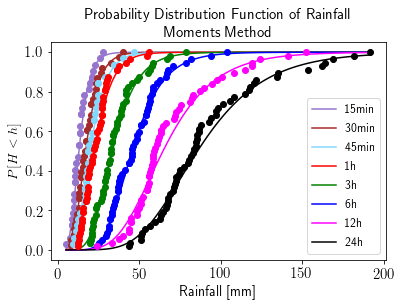

In [51]:
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)


#----------------plot---------------

ax = gb.plot(color = ['#9575cd', 'brown', '#80d8ff','red', 'green', 'blue', 'magenta', 'black'])
#plt.figure(figsize = (18 ,16), dpi = 100)

#--------------15min--------------------
data15min = data['15min'].dropna()
ecdf15min = ECDF(data15min)
ax.plot(data15min, ecdf15min(data15min), 'o', c = '#9575cd')

#--------------30min--------------------
data30min = data['30min'].dropna()
ecdf30min = ECDF(data30min)
ax.plot(data30min, ecdf30min(data30min), 'o', c = 'brown')

#--------------45min--------------------
data45min = data['45min'].dropna()
ecdf45min = ECDF(data45min)
ax.plot(data45min, ecdf45min(data45min), 'o', c = '#80d8ff')

#--------------1h--------------------
data1h = data['1h'].dropna()
ecdf1h = ECDF(data1h)
ax.plot(data1h, ecdf1h(data1h), 'o', c = 'red')

#--------------3h--------------------
data3h = data['3h'].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h, ecdf3h(data3h), 'o', c = 'green')

#--------------6h--------------------
data6h = data['6h'].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h, ecdf6h(data6h), 'o', c = 'blue')

#--------------12h-------------------
data12h = data['12h'].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h, ecdf12h(data12h), 'o', c = 'magenta')

#--------------24h-------------------
data24h = data['24h'].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h, ecdf24h(data24h), 'o', c = 'black')

#-----------------label--------------
ax.set_title('Probability Distribution Function of Rainfall\nMoments Method', fontsize = 15)
ax.set_xlabel('Rainfall [mm]', fontsize = 14)
ax.set_ylabel(r'$P[H < h]$', fontsize = 14)
plt.legend(loc = 4,  fontsize = 12)

#------------------------------------
plt.show()

**dropna()** separa ed elimina i dati NaN.